# A Long-Short Price & Volume Strategy

## Getting the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
plt.style.use("seaborn")
warnings.filterwarnings("ignore")

/var/folders/7j/hl924x6153138p6r1ph4t9xw0000gn/T/ipykernel_98550/4018225526.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
data = pd.read_csv("bitcoin.csv", parse_dates = ["Date"], index_col = "Date")
data

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2021-10-07 05:00:00,55073.20,55073.21,54545.07,54735.76,2251.122020
2021-10-07 06:00:00,54735.77,54968.06,54375.83,54534.16,1783.004260
2021-10-07 07:00:00,54534.16,54793.26,54235.33,54755.92,4163.431360


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36168 entries, 2017-08-17 04:00:00 to 2021-10-07 09:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    36168 non-null  float64
 1   High    36168 non-null  float64
 2   Low     36168 non-null  float64
 3   Close   36168 non-null  float64
 4   Volume  36168 non-null  float64
dtypes: float64(5)
memory usage: 1.7 MB


In [4]:
data = data[["Close", "Volume"]].copy()

In [5]:
data

,Close,Volume
Date,,
2017-08-17 04:00:00,4308.83,47.181009
2017-08-17 05:00:00,4315.32,23.234916
2017-08-17 06:00:00,4324.35,7.229691
2017-08-17 07:00:00,4349.99,4.443249
2017-08-17 08:00:00,4360.69,0.972807
...,...,...
2021-10-07 05:00:00,54735.76,2251.122020
2021-10-07 06:00:00,54534.16,1783.004260
2021-10-07 07:00:00,54755.92,4163.431360


In [6]:
data["returns"] = np.log(data.Close.div(data.Close.shift(1)))
data["vol_ch"] = np.log(data.Volume.div(data.Volume.shift(1)))

In [7]:
data.loc[data.vol_ch > 3, "vol_ch"] = np.nan
data.loc[data.vol_ch < -3, "vol_ch"] = np.nan

In [8]:
data

,Close,Volume,returns,vol_ch
Date,,,,
2017-08-17 04:00:00,4308.83,47.181009,NaN,NaN
2017-08-17 05:00:00,4315.32,23.234916,0.001505,-0.708335
2017-08-17 06:00:00,4324.35,7.229691,0.002090,-1.167460
2017-08-17 07:00:00,4349.99,4.443249,0.005912,-0.486810
2017-08-17 08:00:00,4360.69,0.972807,0.002457,-1.518955
...,...,...,...,...
2021-10-07 05:00:00,54735.76,2251.122020,-0.006146,0.439863
2021-10-07 06:00:00,54534.16,1783.004260,-0.003690,-0.233129
2021-10-07 07:00:00,54755.92,4163.431360,0.004058,0.848040


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36168 entries, 2017-08-17 04:00:00 to 2021-10-07 09:00:00
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Close    36168 non-null  float64
 1   Volume   36168 non-null  float64
 2   returns  36167 non-null  float64
 3   vol_ch   36150 non-null  float64
dtypes: float64(4)
memory usage: 1.4 MB


## Formulating a Long-Short Price/Volume Trading Strategy

In [10]:
data

,Close,Volume,returns,vol_ch
Date,,,,
2017-08-17 04:00:00,4308.83,47.181009,NaN,NaN
2017-08-17 05:00:00,4315.32,23.234916,0.001505,-0.708335
2017-08-17 06:00:00,4324.35,7.229691,0.002090,-1.167460
2017-08-17 07:00:00,4349.99,4.443249,0.005912,-0.486810
2017-08-17 08:00:00,4360.69,0.972807,0.002457,-1.518955
...,...,...,...,...
2021-10-07 05:00:00,54735.76,2251.122020,-0.006146,0.439863
2021-10-07 06:00:00,54534.16,1783.004260,-0.003690,-0.233129
2021-10-07 07:00:00,54755.92,4163.431360,0.004058,0.848040


In [11]:
data["position"] = 0 # Trading position -> Neutral for all bars
data

,Close,Volume,returns,vol_ch,position
Date,,,,,
2017-08-17 04:00:00,4308.83,47.181009,NaN,NaN,0
2017-08-17 05:00:00,4315.32,23.234916,0.001505,-0.708335,0
2017-08-17 06:00:00,4324.35,7.229691,0.002090,-1.167460,0
2017-08-17 07:00:00,4349.99,4.443249,0.005912,-0.486810,0
2017-08-17 08:00:00,4360.69,0.972807,0.002457,-1.518955,0
...,...,...,...,...,...
2021-10-07 05:00:00,54735.76,2251.122020,-0.006146,0.439863,0
2021-10-07 06:00:00,54534.16,1783.004260,-0.003690,-0.233129,0
2021-10-07 07:00:00,54755.92,4163.431360,0.004058,0.848040,0


__Buy and go Long (position = 1) if most recent returns are highly negative (cond1) and trading volume decreased (cond2)__

In [12]:
# getting returns threshold for highly negative returns (<= 10th percentile)
return_thresh = np.percentile(data.returns.dropna(), 10)
return_thresh

-0.007813258140358005

In [13]:
cond1 = data.returns <= return_thresh
cond1

Date
2017-08-17 04:00:00    False
2017-08-17 05:00:00    False
2017-08-17 06:00:00    False
2017-08-17 07:00:00    False
2017-08-17 08:00:00    False
                       ...  
2021-10-07 05:00:00    False
2021-10-07 06:00:00    False
2021-10-07 07:00:00    False
2021-10-07 08:00:00    False
2021-10-07 09:00:00     True
Name: returns, Length: 36168, dtype: bool

In [14]:
# getting vol_ch thresholds for (moderate) Volume Decreases (between 5th and 20th percentile)
volume_thresh = np.percentile(data.vol_ch.dropna(), [5, 20])
volume_thresh

array([-0.72895253, -0.37604441])

In [15]:
cond2 = data.vol_ch.between(volume_thresh[0], volume_thresh[1])
cond2

Date
2017-08-17 04:00:00    False
2017-08-17 05:00:00     True
2017-08-17 06:00:00    False
2017-08-17 07:00:00     True
2017-08-17 08:00:00    False
                       ...  
2021-10-07 05:00:00    False
2021-10-07 06:00:00    False
2021-10-07 07:00:00    False
2021-10-07 08:00:00     True
2021-10-07 09:00:00    False
Name: vol_ch, Length: 36168, dtype: bool

In [16]:
data.loc[cond1 & cond2, "position"] = 1

__Sell and go Short (position = -1) if most recent returns are highly positive (cond3) and trading volume decreased (cond2)__

In [17]:
# getting returns threshold for highly positve returns (>= 90th percentile)
return_thresh = np.percentile(data.returns.dropna(), 90)
return_thresh

0.008231867023808183

In [18]:
cond3 = data.returns >= return_thresh
cond3

Date
2017-08-17 04:00:00    False
2017-08-17 05:00:00    False
2017-08-17 06:00:00    False
2017-08-17 07:00:00    False
2017-08-17 08:00:00    False
                       ...  
2021-10-07 05:00:00    False
2021-10-07 06:00:00    False
2021-10-07 07:00:00    False
2021-10-07 08:00:00    False
2021-10-07 09:00:00    False
Name: returns, Length: 36168, dtype: bool

In [19]:
data.loc[cond3 & cond2, "position"] = -1

In [20]:
data.position.value_counts()

 0    35526
-1      364
 1      278
Name: position, dtype: int64

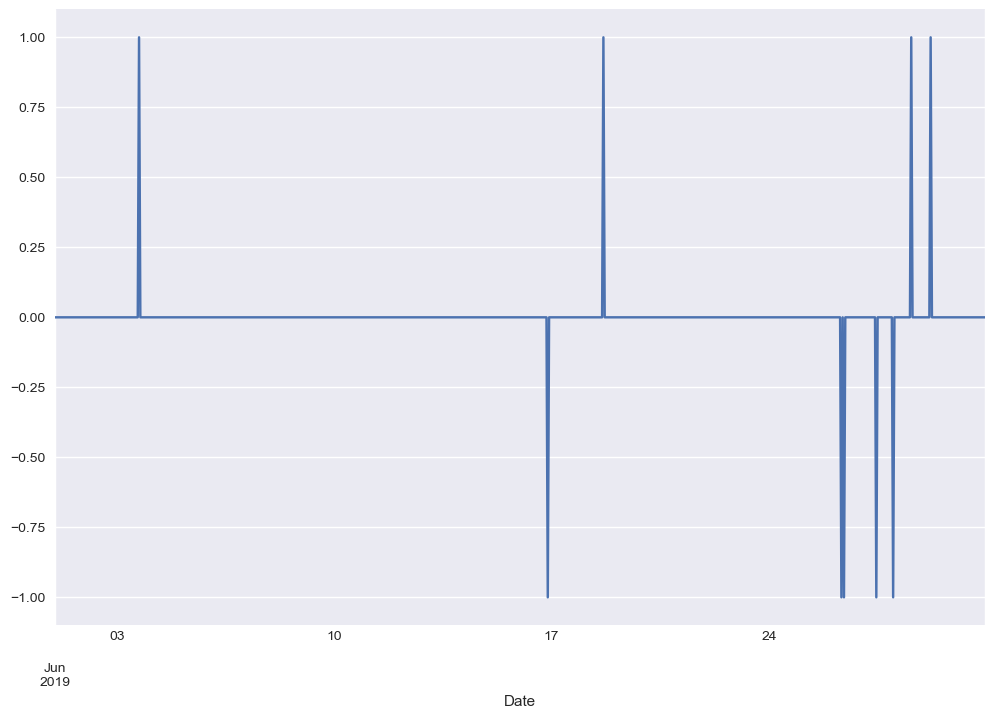

In [21]:
data.loc["06-2019", "position"].plot(figsize = (12, 8))
plt.show()

## A Long-Short Backtester Class

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn")

Major adjustments: 
- Different Strategy Definition with Short Positions (see method prepare_data)
- Four Strategy Parameters (instead of three)

In [23]:
class Long_Short_Backtester():
    ''' Class for the vectorized backtesting of simple Long-Short trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum).
         
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "Long_Short_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw
        
    def test_strategy(self, percentiles = None, thresh = None):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        percentiles: tuple (return_low_perc, return_high_perc, vol_low_perc, vol_high_perc)
            return and volume percentiles to be considered for the strategy.
            
        thresh: tuple (return_low_thresh, return_high_thresh, vol_low_thresh, vol_high_thesh)
            return and volume thresholds to be considered for the strategy.
        '''
        
        self.prepare_data(percentiles = percentiles, thresh = thresh)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, percentiles, thresh):
        ''' Prepares the Data for Backtesting.
        '''
        ########################## Strategy-Specific #############################
        
        data = self.data[["Close", "Volume", "returns"]].copy()
        data["vol_ch"] = np.log(data.Volume.div(data.Volume.shift(1)))
        data.loc[data.vol_ch > 3, "vol_ch"] = np.nan
        data.loc[data.vol_ch < -3, "vol_ch"] = np.nan        
        
        if percentiles:
            self.return_thresh = np.percentile(data.returns.dropna(), [percentiles[0], percentiles[1]])
            self.volume_thresh = np.percentile(data.vol_ch.dropna(), [percentiles[2], percentiles[3]])
        elif thresh:
            self.return_thresh = [thresh[0], thresh[1]]
            self.volume_thresh = [thresh[2], thresh[3]]
                
        cond1 = data.returns <= self.return_thresh[0]
        cond2 = data.vol_ch.between(self.volume_thresh[0], self.volume_thresh[1])
        cond3 = data.returns >= self.return_thresh[1]
        
        data["position"] = 0
        data.loc[cond1 & cond2, "position"] = 1
        data.loc[cond3 & cond2, "position"] = -1

        ##########################################################################
        
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, return_low_range, return_high_range, vol_low_range, vol_high_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        return_low_range: tuple
            tuples of the form (start, end, step size).
        
        return_high_range: tuple
            tuples of the form (start, end, step size).
            
        vol_low_range: tuple
            tuples of the form (start, end, step size).
        
        vol_high_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be "Multiple" or "Sharpe")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        
        return_low_range = range(*return_low_range)
        return_high_range = range(*return_high_range)
        vol_low_range = range(*vol_low_range)
        vol_high_range = range(*vol_high_range)
        
        combinations = list(product(return_low_range, return_high_range, vol_low_range, vol_high_range))
         
        performance = []
        for comb in combinations:
            self.prepare_data(percentiles = comb, thresh = None)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["return_low", "return_high", "vol_low", "vol_high"])
        self.results_overview["performance"] = performance
        self.find_best_strategy()
        
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum).
        '''
        
        best = self.results_overview.nlargest(1, "performance")
        return_perc = [best.return_low.iloc[0], best.return_high.iloc[0]]
        vol_perc = [best.vol_low.iloc[0], best.vol_high.iloc[0]]
        perf = best.performance.iloc[0]
        print("Return_Perc: {} | Volume_Perc: {} | {}: {}".format(return_perc, vol_perc, self.metric, round(perf, 5)))  
        self.test_strategy(percentiles = (return_perc[0], return_perc[1], vol_perc[0], vol_perc[1]))
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
       
        print(100 * "=")
        print("SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = {} | THRESHOLDS = {}, {}".format(self.symbol, np.round(self.return_thresh, 5), np.round(self.volume_thresh, 5)))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)


In [24]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2021-10-07"
tc = -0.00085

In [25]:
tester = Long_Short_Backtester(filepath = filepath, symbol = symbol,
                              start = start, end = end, tc = tc)

In [26]:
tester

Long_Short_Backtester(symbol = BTCUSDT, start = 2017-08-17, end = 2021-10-07)

In [27]:
tester.data

,Open,High,Low,Close,Volume,returns
Date,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,0.001505
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,0.002090
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,0.005912
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,0.002457
...,...,...,...,...,...,...
2021-10-07 05:00:00,55073.20,55073.21,54545.07,54735.76,2251.122020,-0.006146
2021-10-07 06:00:00,54735.77,54968.06,54375.83,54534.16,1783.004260,-0.003690
2021-10-07 07:00:00,54534.16,54793.26,54235.33,54755.92,4163.431360,0.004058


In [34]:
tester.test_strategy(percentiles = (10, 90, 5, 20))

SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = [-0.00781  0.00823], [-0.72895 -0.37604]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         2.524794
Multiple (Buy-and-Hold):     12.53136
--------------------------------------
Out-/Underperformance:       -10.006566


CAGR:                        0.250733
Annualized Mean:             0.223736
Annualized Std:              0.193351
Sharpe Ratio:                1.296776


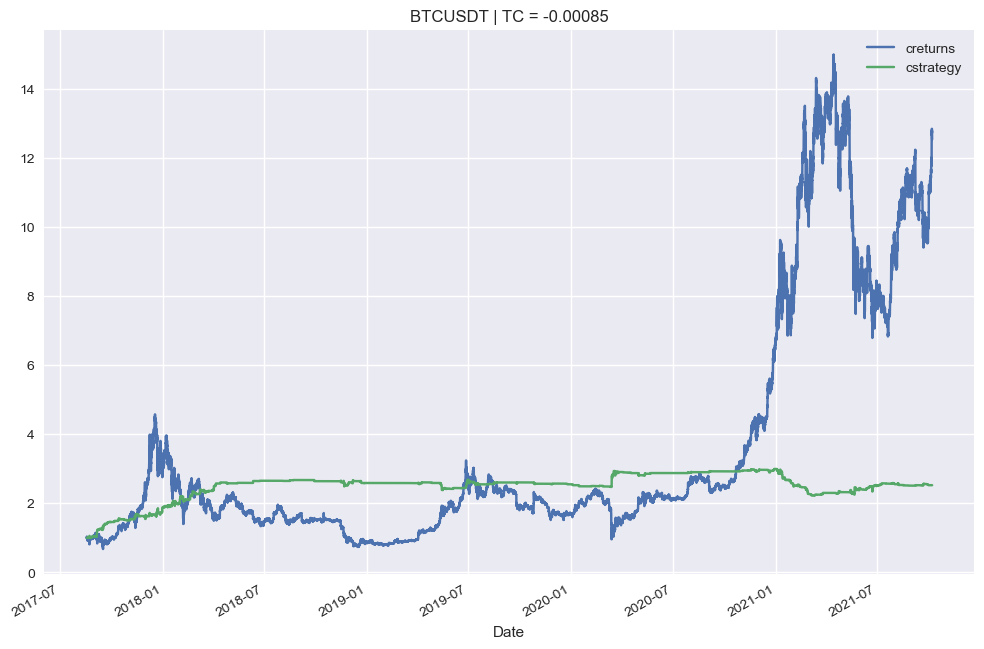

In [35]:
tester.plot_results()

In [36]:
tester.results.trades.value_counts()

0.0    34916
1.0     1232
2.0       20
Name: trades, dtype: int64

In [37]:
tester.optimize_strategy(return_low_range = (2, 20, 2),
                         return_high_range = (80, 98, 2), 
                         vol_low_range = (0, 18, 2), 
                         vol_high_range = (18, 40, 2),
                         metric = "Sharpe")

Return_Perc: [4, 94] | Volume_Perc: [12, 18] | Sharpe: 1.80985
SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = [-0.01527  0.01168], [-0.5182  -0.40675]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         2.133081
Multiple (Buy-and-Hold):     12.53136
--------------------------------------
Out-/Underperformance:       -10.398279


CAGR:                        0.200819
Annualized Mean:             0.183009
Annualized Std:              0.110959
Sharpe Ratio:                1.809846


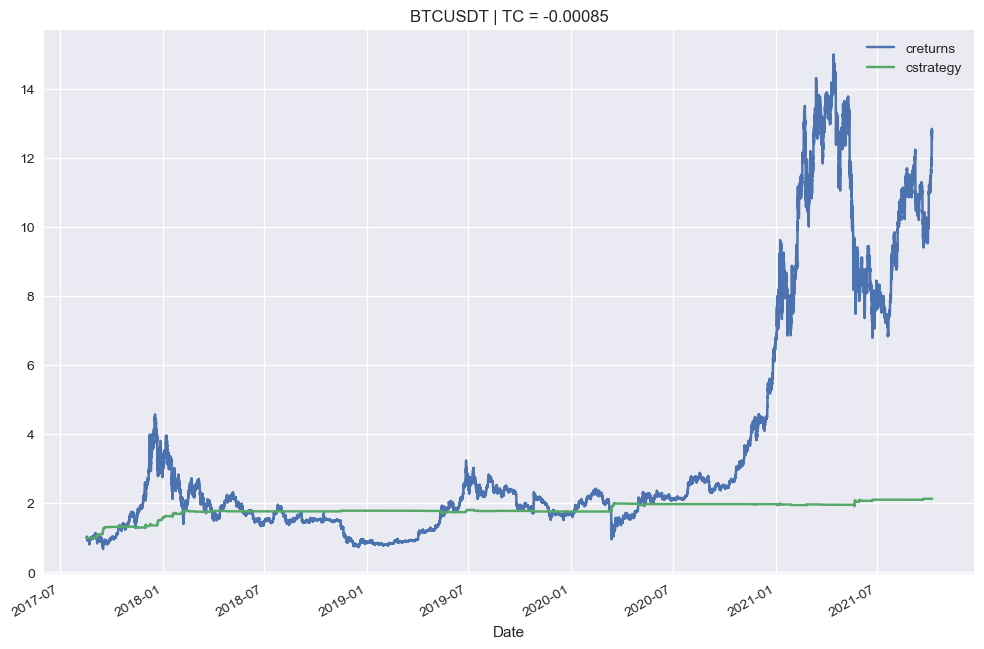

In [38]:
tester.plot_results()

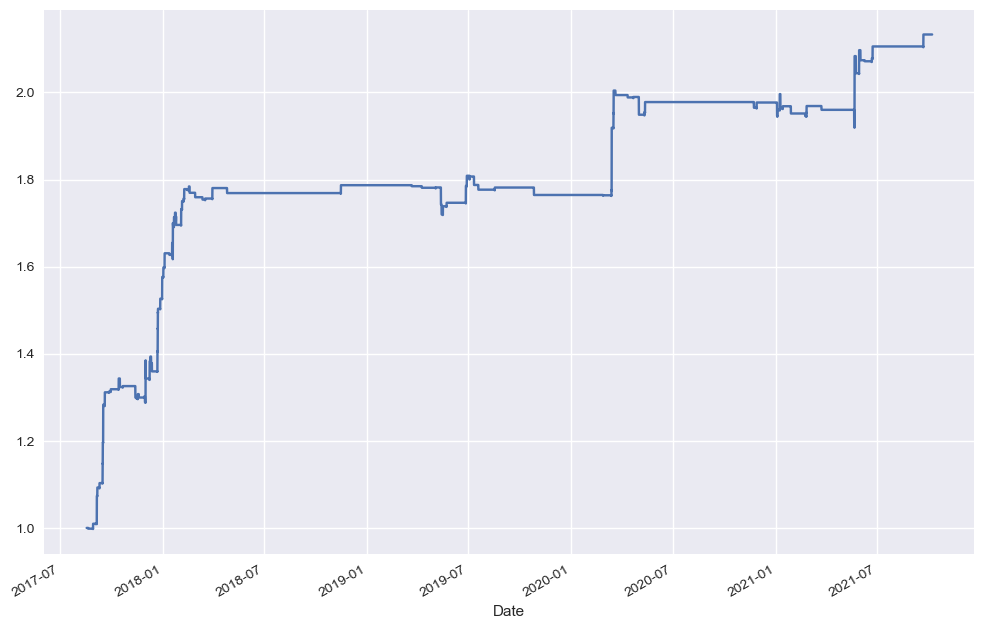

In [39]:
tester.results.cstrategy.plot(figsize = (12,8))
plt.show()

In [40]:
tester.results.position.value_counts()

 0    36053
-1       91
 1       24
Name: position, dtype: int64

In [41]:
tester.results.trades.value_counts()

0.0    35939
1.0      228
2.0        1
Name: trades, dtype: int64

In [42]:
tester.optimize_strategy(return_low_range = (2, 7, 1),
                         return_high_range = (89, 99, 1), 
                         vol_low_range = (8, 14, 1), 
                         vol_high_range = (14, 22, 1),
                         metric = "Sharpe")

Return_Perc: [5, 94] | Volume_Perc: [12, 19] | Sharpe: 1.94716
SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = [-0.01319  0.01168], [-0.5182  -0.39196]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         2.349634
Multiple (Buy-and-Hold):     12.53136
--------------------------------------
Out-/Underperformance:       -10.181726


CAGR:                        0.229197
Annualized Mean:             0.206367
Annualized Std:              0.117708
Sharpe Ratio:                1.947161


## A Long-Short Trader Class

_Disclaimer: <br>
The following illustrative examples are for general information and educational purposes only. <br>
It is neither investment advice nor a recommendation to trade, invest or take whatsoever actions.<br>
The below code should only be used in combination with the Binance Spot Testnet and NOT with a Live Trading Account._

In [43]:
from binance.client import Client
from binance import ThreadedWebsocketManager
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

In [44]:
class LongShortTrader():
    
    def __init__(self, symbol, bar_length, return_thresh, volume_thresh, units, position = 0):
        
        self.symbol = symbol
        self.bar_length = bar_length
        self.available_intervals = ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        self.units = units
        self.position = position
        self.trades = 0 
        self.trade_values = []
        
        #*****************add strategy-specific attributes here******************
        self.return_thresh = return_thresh
        self.volume_thresh = volume_thresh
        #************************************************************************
    
    def start_trading(self, historical_days):
        
        self.twm = ThreadedWebsocketManager()
        self.twm.start()
        
        if self.bar_length in self.available_intervals:
            self.get_most_recent(symbol = self.symbol, interval = self.bar_length,
                                 days = historical_days)
            self.twm.start_kline_socket(callback = self.stream_candles,
                                        symbol = self.symbol, interval = self.bar_length)
        # "else" to be added later in the course 
    
    def get_most_recent(self, symbol, interval, days):
    
        now = datetime.utcnow()
        past = str(now - timedelta(days = days))
    
        bars = client.get_historical_klines(symbol = symbol, interval = interval,
                                            start_str = past, end_str = None, limit = 1000)
        df = pd.DataFrame(bars)
        df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
        df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                      "Clos Time", "Quote Asset Volume", "Number of Trades",
                      "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
        df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
        df.set_index("Date", inplace = True)
        for column in df.columns:
            df[column] = pd.to_numeric(df[column], errors = "coerce")
        df["Complete"] = [True for row in range(len(df)-1)] + [False]
        
        self.data = df
    
    def stream_candles(self, msg):
        
        # extract the required items from msg
        event_time = pd.to_datetime(msg["E"], unit = "ms")
        start_time = pd.to_datetime(msg["k"]["t"], unit = "ms")
        first   = float(msg["k"]["o"])
        high    = float(msg["k"]["h"])
        low     = float(msg["k"]["l"])
        close   = float(msg["k"]["c"])
        volume  = float(msg["k"]["v"])
        complete=       msg["k"]["x"]
        
        # stop trading session
        if self.trades >= 5: # stop stream after 5 trades
            self.twm.stop()
            if self.position == 1:
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL AND STOP")
                self.position = 0
            elif self.position == -1:
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL AND STOP")
                self.position = 0
            else: 
                print("STOP")
    
        # print out
        print(".", end = "", flush = True) # just print something to get a feedback (everything OK) 
    
        # feed df (add new bar / update latest bar)
        self.data.loc[start_time] = [first, high, low, close, volume, complete]
        
        # prepare features and define strategy/trading positions whenever the latest bar is complete
        if complete == True:
            self.define_strategy()
            self.execute_trades()
        
    def define_strategy(self):
        
        df = self.data.copy()
        
        #******************** define your strategy here ************************
        df = df[["Close", "Volume"]].copy()
        df["returns"] = np.log(df.Close / df.Close.shift())
        df["vol_ch"] = np.log(df.Volume.div(df.Volume.shift(1)))
        df.loc[df.vol_ch > 3, "vol_ch"] = np.nan
        df.loc[df.vol_ch < -3, "vol_ch"] = np.nan  
        
        cond1 = df.returns <= self.return_thresh[0]
        cond2 = df.vol_ch.between(self.volume_thresh[0], self.volume_thresh[1])
        cond3 = df.returns >= self.return_thresh[1]
        
        df["position"] = 0
        df.loc[cond1 & cond2, "position"] = 1
        df.loc[cond3 & cond2, "position"] = -1
        #***********************************************************************
        
        self.prepared_data = df.copy()
    
    def execute_trades(self): 
        if self.prepared_data["position"].iloc[-1] == 1: # if position is long -> go/stay long
            if self.position == 0:
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING LONG")  
            elif self.position == -1:
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL")
                time.sleep(0.1)
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING LONG")
            self.position = 1
        elif self.prepared_data["position"].iloc[-1] == 0: # if position is neutral -> go/stay neutral
            if self.position == 1:
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL") 
            elif self.position == -1:
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL") 
            self.position = 0
        if self.prepared_data["position"].iloc[-1] == -1: # if position is short -> go/stay short
            if self.position == 0:
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING SHORT") 
            elif self.position == 1:
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL")
                time.sleep(0.1)
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING SHORT")
            self.position = -1
    
    def report_trade(self, order, going): 
        
        # extract data from order object
        side = order["side"]
        time = pd.to_datetime(order["transactTime"], unit = "ms")
        base_units = float(order["executedQty"])
        quote_units = float(order["cummulativeQuoteQty"])
        price = round(quote_units / base_units, 5)
        
        # calculate trading profits
        self.trades += 1
        if side == "BUY":
            self.trade_values.append(-quote_units)
        elif side == "SELL":
            self.trade_values.append(quote_units) 
        
        if self.trades % 2 == 0:
            real_profit = round(np.sum(self.trade_values[-2:]), 3) 
            self.cum_profits = round(np.sum(self.trade_values), 3)
        else: 
            real_profit = 0
            self.cum_profits = round(np.sum(self.trade_values[:-1]), 3)
        
        # print trade report
        print(2 * "\n" + 100* "-")
        print("{} | {}".format(time, going)) 
        print("{} | Base_Units = {} | Quote_Units = {} | Price = {} ".format(time, base_units, quote_units, price))
        print("{} | Profit = {} | CumProfits = {} ".format(time, real_profit, self.cum_profits))
        print(100 * "-" + "\n")

In [45]:
api_key = "insert here"
secret_key = "insert here"

In [46]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True)

For illustration purposes: a very dynamic Strategy (parameters) with many trades:

In [47]:
symbol = "BTCUSDT"
bar_length = "1m"
return_thresh = [-0.0001, 0.0001]
volume_thresh = [-3, 3]
units = 0.01
position = 0

In [48]:
client.get_account()

BinanceAPIException: APIError(code=-2014): API-key format invalid.

In [ ]:
trader = LongShortTrader(symbol = symbol, bar_length = bar_length, return_thresh = return_thresh,
                        volume_thresh = volume_thresh, units = units, position = position)

In [ ]:
trader.start_trading(historical_days = 1/24)

In [ ]:
trader.prepared_data

In [ ]:
trader.cum_profits

In [ ]:
client.get_account()